# **필요한 라이브러리 불러오기**

In [ ]:
import torch
import torch.nn as nn

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
# device : gpu를 사용할 경우에는 'cuda', 그렇지 않을 경우에는 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 랜덤 시드 고정
# 실험 조건을 동일하게 설정하여 같은 input을 넣으면 같은 결과가 나올 수 있도록 함
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# **Hyper parameter 설정**

In [ ]:
batch_size = 128        # 배치크기
epochs = 15             # 학습 횟수
learning_rate = 0.01    # 학습률

# **MNIST 데이터셋 불러오기**
- 60,000개의 train data, 10,000개의 test data

In [ ]:
train_dataset = datasets.MNIST(root='dataset/', # 다운로드 경로 지정
                               train=True,      # True를 지정하면 훈련 데이터로 다운로드
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor(), # 텐서로 변환
                                                            transforms.Normalize(mean=(0.5,),std=(0.5,))])) # 이미지 정규화
test_dataset = datasets.MNIST(root='dataset/',
                              train=False,      # False를 지정하면 테스트 데이터로 다운로드
                              download=True,
                              transform=transforms.Compose([transforms.ToTensor(),
                                                            transforms.Normalize(mean=(0.5,),std=(0.5,))]))
# Data loader를 사용하여 배치 크기 지정
train_loader=torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# **데이터 시각화**

In [ ]:
# 첫번째 데이터 묶음 반환
images, labels = next(iter(train_loader))

In [ ]:
# 데이터 size 확인
images.shape , labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

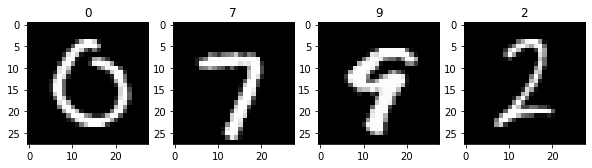

In [ ]:
img = images.squeeze(1).numpy()     # 차원 축소 : [batch, 1, H, W] -> [batch, H, W]
label = labels.numpy()

plt.figure(figsize=(10,20))
plt.subplot(1,4,1)
plt.imshow(img[0],'gray')
plt.title(label[0])
plt.subplot(1,4,2)
plt.imshow(img[1],'gray')
plt.title(label[1])
plt.subplot(1,4,3)
plt.imshow(img[2],'gray')
plt.title(label[2])
plt.subplot(1,4,4)
plt.imshow(img[3],'gray')
plt.title(label[3])
plt.show()

# **모델 설계**
- Multi-layer Perceptron 

In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP,self).__init__()
    self.layer1 = nn.Sequential(nn.Linear(784, 512),     # input : 1 x 28 x 28 = 784 -> output : 512
                                 nn.ReLU())               # activation function은 relu를 사용
    self.layer2 = nn.Sequential(nn.Linear(512, 512),     # input : 512 -> output : 512
                                 nn.ReLU())
    self.layer3 = nn.Sequential(nn.Linear(512, 512),     # input : 512 -> output : 512
                                 nn.ReLU())
    self.layer4 = nn.Linear(512, 10)                     # input : 512 -> output : 분류해야 할 총 class 수 = 10

  def forward(self, x):
    x = x.view(-1, 28*28)   # 2D image -> 1D vector
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    return x

model = MLP().to(device)    # GPU에서 연산 수행하기 위해 device로 보냄

In [ ]:
# 모델 구성 출력
print(model)

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (layer4): Linear(in_features=512, out_features=10, bias=True)
)


# **Train**

In [ ]:
# cost function과 optimizer 정의
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [ ]:
# 모델 학습
model.train()
loss_list = []

for epoch in range(epochs):
  avg_loss = 0.0
  total_loss = 0.0
  for iter, data in enumerate(train_loader):
    optimizer.zero_grad()
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)

    output = model(images)
    loss = criterion(output,labels)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item()
    total_loss += loss.item()

    if (iter+1) % 100==0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.5f}'.format(
      epoch, iter+1, len(train_loader), avg_loss/100.))
      avg_loss = 0.0
  loss_list.append(total_loss/(iter+1))  
print('\nLearning finished!')

Train Epoch: 0 [100/469]	Loss: 2.27017
Train Epoch: 0 [200/469]	Loss: 2.17374
Train Epoch: 0 [300/469]	Loss: 1.93699
Train Epoch: 0 [400/469]	Loss: 1.44047
Train Epoch: 1 [100/469]	Loss: 0.82829
Train Epoch: 1 [200/469]	Loss: 0.67513
Train Epoch: 1 [300/469]	Loss: 0.57984
Train Epoch: 1 [400/469]	Loss: 0.51372
Train Epoch: 2 [100/469]	Loss: 0.44272
Train Epoch: 2 [200/469]	Loss: 0.41633
Train Epoch: 2 [300/469]	Loss: 0.40273
Train Epoch: 2 [400/469]	Loss: 0.39175
Train Epoch: 3 [100/469]	Loss: 0.36048
Train Epoch: 3 [200/469]	Loss: 0.36539
Train Epoch: 3 [300/469]	Loss: 0.34895
Train Epoch: 3 [400/469]	Loss: 0.34125
Train Epoch: 4 [100/469]	Loss: 0.32172
Train Epoch: 4 [200/469]	Loss: 0.32546
Train Epoch: 4 [300/469]	Loss: 0.31585
Train Epoch: 4 [400/469]	Loss: 0.32480
Train Epoch: 5 [100/469]	Loss: 0.30354
Train Epoch: 5 [200/469]	Loss: 0.30027
Train Epoch: 5 [300/469]	Loss: 0.29455
Train Epoch: 5 [400/469]	Loss: 0.28889
Train Epoch: 6 [100/469]	Loss: 0.28809
Train Epoch: 6 [200/469]	

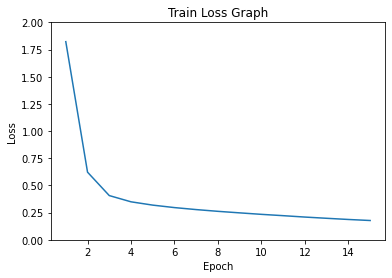

In [ ]:
# Loss graph
plt.plot(range(1,epochs+1), loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.title('Train Loss Graph')
plt.show()

# **Test**

Accuracy : 94.82%
Label:  8
Prediction:  8


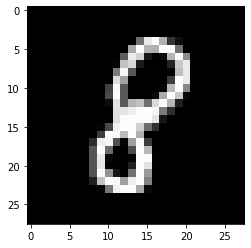

In [ ]:
# 모델 성능 확인
with torch.no_grad(): # torch.no_grad(): gradient 계산을 수행하지 않음
  model.eval()
  accuracy = 0.0

  for iter, data in enumerate(test_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)

    # 모델이 예측한 값과 실제 레이블인 labels를 비교
    # argmax 함수를 이용해 예측한 값 중 가장 확률이 높은 값을 예측 값으로 사용 (예) [0.1,0.05,0.7,0,0,0.15] -> 2
    pred = torch.argmax(output,1) == labels
    accuracy += pred.float().sum()
    
  print("Accuracy : {:.2f}%".format(100*accuracy/len(test_dataset)))

  # 테스트 데이터에서 무작위로 하나를 뽑아서 예측
  r = random.randint(0, len(test_dataset) - 1)
  X_single_data = test_dataset.data[r:r + 1].view(1, 1, 28, 28).float().to(device)
  Y_single_data = test_dataset.targets[r:r + 1].to(device)

  print('Label: ', Y_single_data.item())
  single_prediction = model(X_single_data)
  print('Prediction: ', torch.argmax(single_prediction, 1).item())

  plt.imshow(test_dataset.data[r:r + 1].view(28, 28), cmap='gray')
  plt.show()

# **모델 저장**

In [ ]:
# 모델의 weight만 저장
torch.save(model.state_dict(),'mlp_weight.pth')

In [ ]:
# 모델 통째로 저장
torch.save(model,'mlp.pth')

# **저장된 모델 불러오기**

In [ ]:
# 모델의 weight만 불러오기
checkpoint = torch.load('mlp_weight.pth', map_location = device)
model.load_state_dict(checkpoint)
model.eval()

In [ ]:
# 모델 통째로 불러오기
model = torch.load('mlp.pth', map_location = device)
model.eval()